In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich


from dotenv import load_dotenv

load_dotenv()

HF_API_TOKEN = os.getenv("HF_API_TOKEN")
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")

In [2]:
from haystack import Pipeline
from haystack.components.routers import ConditionalRouter
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.websearch.serper_dev import SerperDevWebSearch #conditional router

from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersTextEmbedder

from haystack.utils import Secret

In [3]:
document_store = ElasticsearchDocumentStore(hosts = "http://localhost:9200")

In [32]:
rag_prompt_template = """
Answer the following query given the documents.
Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""
query_embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever =ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 3)
prompt = PromptBuilder(template=rag_prompt_template)
generator = OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))

rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever",retriever )
rag.add_component("prompt_builder", prompt)
rag.add_component("generator", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder", "generator")


🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: ElasticsearchEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

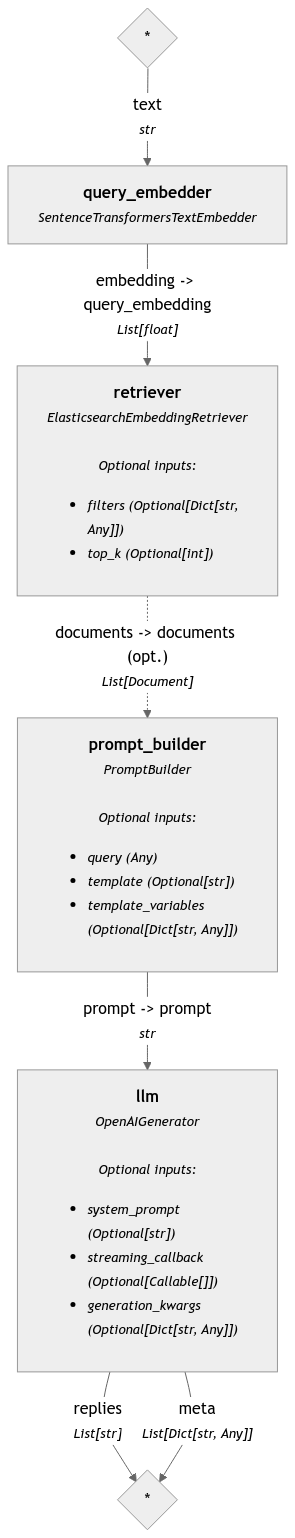

In [16]:
rag.show()

In [17]:
query = "Who is J. R.R. Tolkien?"

result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query}},
        include_outputs_from={"retriever"}
)


Batches: 100%|██████████| 1/1 [00:00<00:00, 34.40it/s]


In [18]:
rich.print(result["llm"]["replies"][0])

J. R. R. Tolkien, whose full name is John Ronald Reuel Tolkien, was born on January 3, 1892, in Bloemfontein, South
Africa. He is widely regarded as one of the most influential and celebrated figures in literary history, 
particularly noted for his contributions to the high fantasy genre. His early life experiences, including being 
homeschooled by his mother, played a significant role in shaping his imagination and creative direction.

## Evaluate the Pipeline

For this tutorial, let's evaluate the pipeline with the following metrics since we don't have ground-truth labels:

- [ContextRelevace](https://docs.haystack.deepset.ai/docs/contextrelevanceevaluator): Uses an LLM to evaluate whether contexts are relevant to a question. It does not require ground truth labels.
- [Faithfulness](https://docs.haystack.deepset.ai/docs/faithfulnessevaluator): Uses an LLM to evaluate whether a generated answer can be inferred from the provided contexts. Does not require ground truth labels.


For a full list of available metrics, check out the [Haystack Evaluators](https://docs.haystack.deepset.ai/docs/)

In [19]:
from haystack import Pipeline
from haystack.components.evaluators import ContextRelevanceEvaluator, FaithfulnessEvaluator

eval_pipeline = Pipeline()
eval_pipeline.add_component("context_relevance", ContextRelevanceEvaluator(api_key=Secret.from_token(OPENAI_API_TOKEN), progress_bar=True, raise_on_failure=False))
eval_pipeline.add_component("faithfulness", FaithfulnessEvaluator(api_key=Secret.from_token(OPENAI_API_TOKEN), progress_bar = True, raise_on_failure=False))

In [23]:
questions = ["Who is Tolkien?", "What did Tolkien write?", "Which is the 'The Hobbit' plot?", 
             "Tell me somthing about 'The Lord of the Rings", "Who is George Martin?", "What is 'A Song of Ice and Fire'?",
             "Where George Martin was born?", "What about Game of Thrones?"]

In [ ]:
predicted_answers = []
retrieved_context = []

for question in questions: # loops over questions
  result = rag.run({"query_embedder":{"text":question}, "prompt_builder":{"query": question}}, include_outputs_from={"retriever"})
  predicted_answers.append(result["generator"]["replies"][0])
  retrieved_context.append(result["retriever"]["documents"])

Batches: 100%|██████████| 1/1 [00:00<00:00, 30.31it/s]


In [25]:
predicted_answers

['Tolkien refers to John Ronald Reuel Tolkien, who was born on January 3, 1892, in Bloemfontein, South Africa. He is widely regarded as one of the most influential and celebrated figures in literary history, particularly in the genre of high fantasy. His notable work includes "The Hobbit," which marked his emergence as a prominent author, and he is best known for creating the fictional universe of Middle-earth, which became a lifelong project that extended beyond a single book.',
 'Tolkien wrote novels, essays, and letters. Notably, he is known for his works set in Middle-earth, including "The Hobbit," which marked his emergence as a prominent author. His creative process and the philosophical foundations of his work are discussed in his essays and letters.',
 'The plot of "The Hobbit" follows Bilbo Baggins, a hobbit who embarks on a thrilling adventure with a group of dwarves and the wizard Gandalf. Initially conceived as a tale for children, the story explores themes of adventure and

In [26]:
retrieved_context

[[Document(id=eb52caac452836a9399da7a3336499f83d9cf7a2b12a76f94c93fbfc3226017e, content: ' Tolkien, Robert E.', meta: {'file_path': 'data/George_RR_Martin.txt', 'source_id': '15be1c5b294259e1edd84ceaad98bd72b06602ec7dbd50d41da58fae2539e261', 'page_number': 1, 'split_id': 10, 'split_idx_start': 818}, score: 0.89445496, embedding: vector of size 384),
  Document(id=41adfcdd6346f3f115b5a7f4a64833d1a55557e467077bc34acb3ee2166a0c9d, content: 'John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarde...', meta: {'file_path': 'data/tolkien.txt', 'source_id': 'c4d35e2d2f05046acfb4acec088ffc4e6e7cddad980d9f1a4feb9a9683ef9e06', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}, score: 0.8402337, embedding: vector of size 384),
  Document(id=58e0ea95c92752d4499f3dbd05057e60b3fc1ecf702ee2dd400258d65491b778, content: ' The success of The Hobbit marked Tolkien’s emergence as a prominent author, and his creation of Mid...', meta: {'file_path': 'data/tol

In [ ]:
eval_pipeline_results = eval_pipeline.run(
    {
        "context_relevance": {"questions": questions, "contexts": retrieved_context},
        "faithfulness": {"questions": questions, "contexts": retrieved_context, "predicted_answers": predicted_answers},
    }
)

results = {
    "context_relevance": eval_pipeline_results['context_relevance'],
    "faithfulness": eval_pipeline_results['faithfulness'],
}

100%|██████████| 8/8 [00:26<00:00,  3.33s/it]


In [29]:
results

{'context_relevance': {'results': [{'relevant_statements': ['John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded...'],
    'score': 1},
   {'relevant_statements': ['The success of The Hobbit marked Tolkien’s emergence as a prominent author, and his creation of Middle-earth is widely regarded as one of the most significant achievements in modern fantasy literature.'],
    'score': 1},
   {'relevant_statements': ['The story follows Bilbo Baggins, a hobbit who embarks on a thrilling adventure with a group of dwar.'],
    'score': 1},
   {'relevant_statements': ['This creative circle played a significant role in the development of The Lord of the Rings.',
     'The cinematic adaptations of The Lord of the Rings and The Hobbit, directed by Peter Jackson, introduced new audiences to the stories.',
     'Published in three volumes between 1954 and 1955—The Fellowship of the Ring, The Two Towers, and The Return of the King.'],
    'score': 1},


In [30]:
from haystack.evaluation import EvaluationRunResult

inputs = {
    'questions': questions,
    'contexts': retrieved_context,
    'predicted_answers': predicted_answers
}
run_name="rag_eval"
eval_results = EvaluationRunResult(run_name=run_name, inputs=inputs, results=results)
eval_results.score_report()

,metrics,score
0,context_relevance,1.0
1,faithfulness,1.0


In [31]:
eval_results.to_pandas()

,questions,contexts,predicted_answers,context_relevance,faithfulness
0,Who is Tolkien?,[Document(id=eb52caac452836a9399da7a3336499f83...,"Tolkien refers to John Ronald Reuel Tolkien, w...",1,1.0
1,What did Tolkien write?,[Document(id=14d31bb6c3f0fc4cca57d6ef12ec25c9c...,"Tolkien wrote novels, essays, and letters. Not...",1,1.0
2,Which is the 'The Hobbit' plot?,[Document(id=d2ff2152215d26795c386e999a1892232...,"The plot of ""The Hobbit"" follows Bilbo Baggins...",1,1.0
3,Tell me somthing about 'The Lord of the Rings,[Document(id=cc302a11fe5a0e258837e473e3c060882...,The Lord of the Rings is a high-fantasy epic w...,1,1.0
4,Who is George Martin?,[Document(id=a630c12276bfbb41aefc896ddbe93b9b9...,"George Raymond Richard Martin, commonly known ...",1,1.0
5,What is 'A Song of Ice and Fire'?,[Document(id=f432d524fecfc217dd49c6bf4678f3c21...,'A Song of Ice and Fire' is a series of epic f...,1,1.0
6,Where George Martin was born?,[Document(id=a630c12276bfbb41aefc896ddbe93b9b9...,"George Martin was born in Bayonne, New Jersey.",1,1.0
7,What about Game of Thrones?,[Document(id=ed9783a68e53dbc74e6f0e06522f33cda...,Game of Thrones is a television series that wa...,1,1.0
